# Galapagos Project -- 16S and ITS rRNA gene data

## Title: Microclimate is a strong predictor of the native and invasive plant-associated soil microbiota on San Cristobal Island, Galapagos archipelago

66S and ITS rRNA gene data from Galapagos soil sample were analyzed using this workflow (adapted from the LangilleLab workflow and Qiime tutorials). We used Qiime2, v2020.8.
 
Alexi A. Schoenborn*,1, Sarah M. Yannarell*,1, Caroline T. MacVicar2, Noelia N. Barriga-Medina5,6, Meng Markillie7, Hugh Mitchell7, Kevin S. Bonham2, Antonio Leon-Reyes5,6, Diego Riveros-Iregui3,4,5, Vanja Klepac-Ceraj2,#, Elizabeth A. Shank8,# 

https://github.com/LangilleLab/microbiome_helper/wiki/Amplicon-SOP-v2-(qiime2-2020.8)
http://qiime2.org


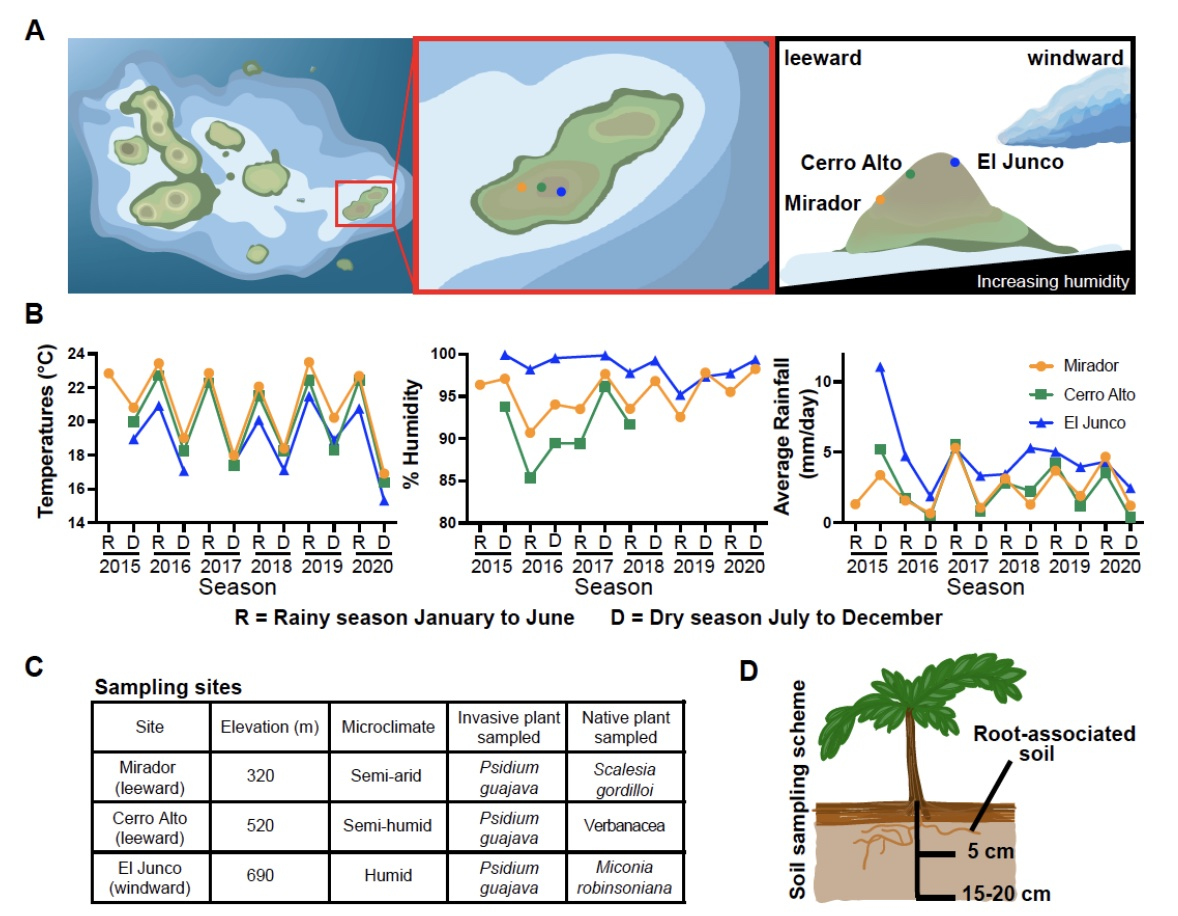

Figure 1. Within a small spatial scale, San Cristobal Island, Galapagos Archipelago, experiences distinct microclimates. (A) The Galapagos Islands are a series of islands formed from Volcanic activity. Our three field sites were located on the oldest island, San Cristobal, and had weather stations installed in 2015; Mirador (arid site - 320 m), Cerro Alto (semi-arid - 520 m) and El Junco (humid - 690 m). (B) Weather data; temperature, humidity and precipitation collected and monitored since 2015 to present, R = rainy season (January - June), D = dry season (July - December), data are the average of collections for the given season. Due to remote locations, some weather station data is absent (missing line). (C) table detailing the microclimates and different plant species we collected soil from at each site. (D) Image relaying our soil sampling scheme per plant (i) rhizosphere (root associated soil), (ii) 5 cm below the plant, and (iii) 15-20 cm below the plant, totalling 3 soil samples per plant.

In [ ]:
from os import chdir, mkdir
from os.path import join
#the following are only available in the current development branch of IPython
from IPython.display import FileLinks, FileLink

%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
project_name = "GALAPAGOS SOIL MICROBIOME"
mapping_file = "./GalapagosMeta2.txt"
classifier = "./classifiers/silva-138-99-nb-classifier.qza"
NCORES = 2
#to avoid changing mapping file / classifier throughout the code, just refer to it by typing $mapping_file

## Import Raw Sequence files as Qiime 2 artifact
This allows for standardization of QIIME 2 analyses and keeps track of all commands that were run to produce a file. The extension for the artifact files is QZA.

In [ ]:
!mkdir reads_qza
!qiime tools import \
     --type 'SampleData[PairedEndSequencesWithQuality]' \
     --input-path manifest_file.csv \
     --output-path reads_qza/reads.qza \
     --input-format PairedEndFastqManifestPhred33

: 

In [ ]:
!qiime demux summarize \
  --i-data reads_qza/reads.qza \
  --o-visualization reads_qza/reads.qzv \
  --p-n 100000 \
  --verbose

In [ ]:
!qiime tools validate reads_qza/reads.qza 

## Trim primers with cutadapt
Trim primers with cutadapt - remove all primers and take out all sequences that don't begin with primer sequence  
I *think* that these primers below are the correct primers for bacteria

... Bacteria-specific ("Illumina")	V3-V4	
... 16S rRNA gene 341F = CCTACGGGNGGCWGCAG	
....16S rRNA gene 805R = GGACTACHVGGGTWTCTAAT  

... Fungi-specific primers:
... ITS 9F GAACGCAGCRAAIIGYGA
... ITS4R TCCTCCGCTTATTGATATGC

for more information on cutadapt plugin: https://cutadapt.readthedocs.io/en/stable/guide.html

CITE: DOI:10.14806/ej                                   

In [ ]:
!qiime cutadapt trim-paired \
   --i-demultiplexed-sequences reads_qza/reads.qza \
   --p-cores 3 \
   --p-front-f CCTACGGGNGGCWGCAG \
   --p-front-r GACTACHVGGGTWTCTAAT \
   --p-discard-untrimmed \
   --p-no-indels \
   --o-trimmed-sequences reads_qza/Bactreads_trimmed.qza

In [ ]:
!qiime cutadapt trim-paired \
   --i-demultiplexed-sequences reads_qza/reads.qza \
   --p-cores 3 \
   --p-front-f GAACGCAGCRAA \
   --p-front-r TCCTCCGCTTATTGATATGC \
   --p-discard-untrimmed \
   --p-no-indels \
   --o-trimmed-sequences reads_qza/ITSreads_trimmed.qza

## Summarize trimmed FASTQs
qiime demux summarize command gives back a report of the number of reads per sample and quality distribution across the reads.

In [ ]:
!qiime demux summarize \
   --i-data reads_qza/Bactreads_trimmed.qza \
   --o-visualization reads_qza/Bactreads_trimmed_summary.qzv

!qiime demux summarize \
   --i-data reads_qza/ITSreads_trimmed.qza \
   --o-visualization reads_qza/ITSreads_trimmed_summary.qzv

## Stitching the reads together and denoising paired-end sequences into the amplicon sequence variants (ASVs) using DADA2

This method stitches reads together, denoises paired-end sequences, dereplicates them and filters out chimeras and poor-quality reads

CITE: doi:10.1038/nmeth.3869

In [ ]:
!qiime dada2 denoise-paired --i-demultiplexed-seqs reads_qza/Bactreads_trimmed.qza \
                          --p-trunc-len-f 240 \
                          --p-trunc-len-r 220 \
                          --p-max-ee-f 2 \
                          --p-max-ee-r 3 \
                          --p-n-threads 2 \
                          --output-dir dada2_Bactoutput --verbose

!qiime dada2 denoise-paired --i-demultiplexed-seqs reads_qza/ITSreads_trimmed.qza \
                          --p-trunc-len-f 220 \
                          --p-trunc-len-r 220 \
                          --p-max-ee-f 2 \
                          --p-max-ee-r 3 \
                          --p-n-threads 2 \
                          --output-dir dada2_ITSoutput --verbose

In [ ]:
!qiime tools export --input-path dada2_Bactoutput/denoising_stats.qza --output-path dada2_Bactoutput
!qiime tools export --input-path dada2_ITSoutput/denoising_stats.qza --output-path dada2_ITSoutput

In [ ]:
#summarizing DADA2 output
!qiime feature-table summarize --i-table dada2_Bactoutput/table.qza --o-visualization dada2_Bactoutput/table_summary.qzv
!qiime feature-table summarize --i-table dada2_ITSoutput/table.qza --o-visualization dada2_ITSoutput/table_summary.qzv


# Assign taxonomy to ASVs
Assign taxonomy to your ASVs using a Naive-Bayes approach implemented in the scikit learn Python library and the SILVA database. 
  
###  Taxonomic classifier
The full-length 16S/18S classifier was downloaded from the QIIME 2 website (silva-138-99-nb-classifier.qza for the latest classifier). Fungal ITS classifier was downloaded from?
 
### Run taxonomic classification
You can run the taxonomic classification with this command, which is one of the longest running and most memory-intensive command of the SOP.

In [ ]:
#bacterial classifier
!qiime feature-classifier classify-sklearn --i-reads dada2_Bactoutput/representative_sequences.qza\
                                          --i-classifier silva-138-99-nb-classifier.qza \
                                          --p-n-jobs 1 \
                                          --output-dir BACTtaxa \
--verbose



In [ ]:
#fungal ITS classifier

!qiime feature-classifier classify-sklearn --i-reads dada2_ITSoutput/representative_sequences.qza\
                                          --i-classifier classifier_sh_refs_qiime_ver8_99_s_04.02.2020_ITS.qza \
                                          --p-n-jobs 1 \
                                          --output-dir ITStaxa \
--verbose

As with all QZA files, you can export the output file to take a look at the classifications and confidence scores:

In [ ]:
!qiime tools export --input-path BACTtaxa/classification.qza --output-path BACTtaxa

!qiime tools export --input-path ITStaxa/classification.qza --output-path ITStaxa

In [ ]:
#generate stacked barchart of relative taxon abundances
!qiime taxa barplot \
   --i-table dada2_Bactoutput/table.qza \
   --i-taxonomy BACTtaxa/classification.qza \
   --m-metadata-file $mapping_file \
   --o-visualization BACTtaxa/taxa_barplot.qzv

!qiime taxa barplot \
   --i-table dada2_ITSoutput/table.qza \
   --i-taxonomy ITStaxa/classification.qza \
   --m-metadata-file $mapping_file \
   --o-visualization ITStaxa/taxa_barplot.qzv


## Assess subset of taxonomic scores by blast
The performance of the taxonomic classification is difficult to assess without a gold-standard reference, but nonetheless one basic sanity check is to compare the taxonomic assignments with the top BLASTn hits for certain ASVs.


In [ ]:
!qiime feature-table tabulate-seqs --i-data dada2_Bactoutput/representative_sequences.qza \
                                   --o-visualization dada2_Bactoutput/representative_sequences.qzv

!qiime feature-table tabulate-seqs --i-data dada2_ITSoutput/representative_sequences.qza \
                                   --o-visualization dada2_ITSoutput/representative_sequences.qzv

In [ ]:
#filtering out rare ASVs (removed samples all samples that are <0.1% mean sample depth; mean sample depth =17,560 )
!qiime feature-table filter-features --i-table dada2_Bactoutput/table.qza \
                                    --p-min-frequency 224 \
                                    --p-min-samples 4 \
                                    --o-filtered-table dada2_Bactoutput/table_filt.qza

!qiime feature-table filter-features --i-table dada2_ITSoutput/table.qza \
                                    --p-min-frequency 65 \
                                    --p-min-samples 4 \
                                    --o-filtered-table dada2_ITSoutput/table_filt.qza

In [ ]:
!qiime feature-table filter-seqs --i-data dada2_Bactoutput/representative_sequences.qza \
                             --i-table dada2_Bactoutput/table_filt.qza \
                             --o-filtered-data dada2_Bactoutput/rep_seqs_filt.qza

!qiime feature-table filter-seqs --i-data dada2_ITSoutput/representative_sequences.qza \
                             --i-table dada2_ITSoutput/table_filt.qza \
                             --o-filtered-data dada2_ITSoutput/rep_seqs_filt.qza

In [ ]:
#filtering out contaminant and unclassified ASVs
!qiime taxa filter-table \
   --i-table dada2_Bactoutput/table_filt.qza \
   --i-taxonomy BACTtaxa/classification.qza \
   --p-include p__ \
   --p-exclude mitochondria,chloroplast \
   --o-filtered-table dada2_Bactoutput/dada2_table_filt_contam.qza

!qiime taxa filter-table \
   --i-table dada2_ITSoutput/table_filt.qza \
   --i-taxonomy ITStaxa/classification.qza \
   --p-include p__ \
   --o-filtered-table dada2_ITSoutput/dada2_table_filt_contam.qza

After filtering this is what remains:
BACTERIA:
J12-A	555568 <---max
C7-A	157151
C3-A	156990
M5-C	33039  <-- use 33,000 as a min cutoff

ITS:
C2-A	105710 <--- max
M12-C	20028  <-- use 20,000 as a min cutoff.
C1-B	2037
C3-C	548
M6-A	7

In [ ]:
!qiime feature-table summarize \
   --i-table dada2_Bactoutput/dada2_table_filt_contam.qza \
   --o-visualization dada2_Bactoutput/dada2_table_filt_contam_summary.qzv

!qiime feature-table summarize \
   --i-table dada2_ITSoutput/dada2_table_filt_contam.qza \
   --o-visualization dada2_ITSoutput/dada2_table_filt_contam_summary.qzv

In [ ]:
!qiime diversity alpha-rarefaction \
   --i-table dada2_Bactoutput/dada2_table_filt_contam.qza \
   --p-max-depth 555565 \
   --p-steps 100 \
   --p-metrics 'observed_features' \
   --o-visualization dada2_Bactoutput/rarefaction_curves_test.qzv

!qiime diversity alpha-rarefaction \
   --i-table dada2_ITSoutput/dada2_table_filt_contam.qza \
   --p-max-depth 105710 \
   --p-steps 100 \
   --p-metrics 'observed_features' \
   --o-visualization dada2_ITSoutput/rarefaction_curves_test.qzv

In [ ]:
#generate stacked barchart of relative taxon abundances prior to sample cutoff (2 samples low sequence number)
!qiime taxa barplot \
   --i-table dada2_Bactoutput/dada2_table_filt_contam.qza \
   --i-taxonomy BACTtaxa/classification.qza \
   --m-metadata-file $mapping_file \
   --o-visualization BACTtaxa/taxa_barplot_beforecutoff.qzv

#generate stacked barchart of relative taxon abundances prior to sample cutoff (2 samples low sequence number)
!qiime taxa barplot \
   --i-table dada2_ITSoutput/dada2_table_filt_contam.qza \
   --i-taxonomy ITStaxa/classification.qza \
   --m-metadata-file $mapping_file \
   --o-visualization ITStaxa/taxa_barplot_beforecutoff.qzv

In [ ]:
!qiime feature-table filter-samples \
   --i-table dada2_Bactoutput/dada2_table_filt_contam.qza \
   --p-min-frequency 33000 \
   --o-filtered-table dada2_Bactoutput/dada2_table_final.qza

!qiime feature-table filter-samples \
   --i-table dada2_ITSoutput/dada2_table_filt_contam.qza \
   --p-min-frequency 20000 \
   --o-filtered-table dada2_ITSoutput/dada2_table_final.qza

#setting a cutoff at 33k sequences for Bacteria, and 21,000 for ITS sequences. ITS's M6A, C3-C, C1B did not make it

In [ ]:
!qiime feature-table filter-seqs \
   --i-data dada2_Bactoutput/representative_sequences.qza \
   --i-table dada2_Bactoutput/dada2_table_final.qza \
   --o-filtered-data dada2_Bactoutput/rep_seqs_final.qza

!qiime feature-table filter-seqs \
   --i-data dada2_ITSoutput/representative_sequences.qza \
   --i-table dada2_ITSoutput/dada2_table_final.qza \
   --o-filtered-data dada2_ITSoutput/rep_seqs_final.qza

In [ ]:
!qiime feature-table summarize \
   --i-table dada2_Bactoutput/dada2_table_final.qza \
   --o-visualization dada2_Bactoutput/dada2_table_final_summary.qzv

!qiime feature-table summarize \
   --i-table dada2_ITSoutput/dada2_table_final.qza \
   --o-visualization dada2_ITSoutput/dada2_table_final_summary.qzv

In [ ]:
#generate stacked barchart of relative taxon abundances 
!qiime taxa barplot \
   --i-table dada2_Bactoutput/dada2_table_final.qza \
   --i-taxonomy BACTtaxa/classification.qza \
   --m-metadata-file $mapping_file \
   --o-visualization BACTtaxa/taxa_barplot.qzv

!qiime taxa barplot \
   --i-table dada2_ITSoutput/dada2_table_final.qza \
   --i-taxonomy ITStaxa/classification.qza \
   --m-metadata-file $mapping_file \
   --o-visualization ITStaxa/taxa_barplot.qzv

## build tree using MAFFT fastree plugin


In [ ]:
#!qiime phylogeny align-to-tree-mafft-fasttree --help

In [ ]:
!qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences dada2_Bactoutput/rep_seqs_final.qza \
  --o-alignment dada2_Bactoutput/aligned-rep-seqs.qza \
  --o-masked-alignment dada2_Bactoutput/masked-aligned-rep-seqs.qza \
  --o-tree dada2_Bactoutput/unrooted-tree.qza \
  --o-rooted-tree dada2_Bactoutput/rooted-tree.qza

!qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences dada2_ITSoutput/rep_seqs_final.qza \
  --o-alignment dada2_ITSoutput/aligned-rep-seqs.qza \
  --o-masked-alignment dada2_ITSoutput/masked-aligned-rep-seqs.qza \
  --o-tree dada2_ITSoutput/unrooted-tree.qza \
  --o-rooted-tree dada2_ITSoutput/rooted-tree.qza

In [ ]:
!qiime diversity alpha-rarefaction \
   --i-table dada2_Bactoutput/dada2_table_final.qza \
   --p-max-depth 33000 \
   --p-steps 50 \
   --m-metadata-file $mapping_file \
   --i-phylogeny dada2_Bactoutput/rooted-tree.qza \
   --o-visualization Bactrarefaction_curves_eachsample.qzv

!qiime diversity alpha-rarefaction \
   --i-table dada2_ITSoutput/dada2_table_final.qza \
   --p-max-depth 20000 \
   --p-steps 50 \
   --m-metadata-file $mapping_file \
   --i-phylogeny dada2_ITSoutput/rooted-tree.qza \
   --o-visualization ITSrarefaction_curves_eachsample.qzv

Calculating diversity metrics and generating ordination plots
Common alpha and beta-diversity metrics can be calculated with a single command in QIIME2. In addition, ordination plots (such as PCoA plots for weighted UniFrac distances) will be generated automatically as well. This command will also rarefy all samples to the sample sequencing depth before calculating these metrics (X is a placeholder for the lowest reasonable sample depth; samples with depth below this cut-off will be excluded).

In [ ]:
!qiime diversity core-metrics-phylogenetic \
   --i-table dada2_Bactoutput/dada2_table_final.qza \
   --i-phylogeny dada2_Bactoutput/rooted-tree.qza \
   --p-sampling-depth 33000 \
   --m-metadata-file  $mapping_file \
   --output-dir BACTdiversity

!qiime diversity core-metrics-phylogenetic \
   --i-table dada2_ITSoutput/dada2_table_final.qza \
   --i-phylogeny dada2_ITSoutput/rooted-tree.qza \
   --p-sampling-depth 20000 \
   --m-metadata-file $mapping_file  \
   --output-dir ITSdiversity

In [ ]:
!qiime diversity alpha-group-significance \
   --i-alpha-diversity BACTdiversity/shannon_vector.qza \
   --m-metadata-file $mapping_file \
   --o-visualization BACTdiversity/shannon_compare_groups.qzv

!qiime diversity alpha-group-significance \
   --i-alpha-diversity ITSdiversity/shannon_vector.qza \
   --m-metadata-file $mapping_file \
   --o-visualization ITSdiversity/shannon_compare_groups.qzv

In [ ]:
!qiime diversity alpha-group-significance \
   --i-alpha-diversity BACTdiversity/evenness_vector.qza \
   --m-metadata-file $mapping_file \
   --o-visualization BACTdiversity/evenness_compare_groups.qzv

!qiime diversity alpha-group-significance \
   --i-alpha-diversity ITSdiversity/evenness_vector.qza \
   --m-metadata-file $mapping_file \
   --o-visualization ITSdiversity/evennes_compare_groups.qzv

In [ ]:
!qiime tools export \
   --input-path dada2_output/rep_seqs_final.qza \
   --output-path dada2_output_exported